Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:1

In [16]:
import numpy as np

In [17]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure

In [18]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [19]:
y.shape

(70000,)

(-0.5, 27.5, 27.5, -0.5)

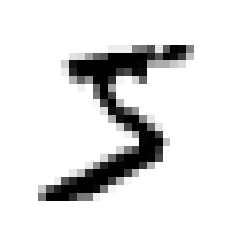

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")


In [21]:
y[0]

'5'

In [22]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

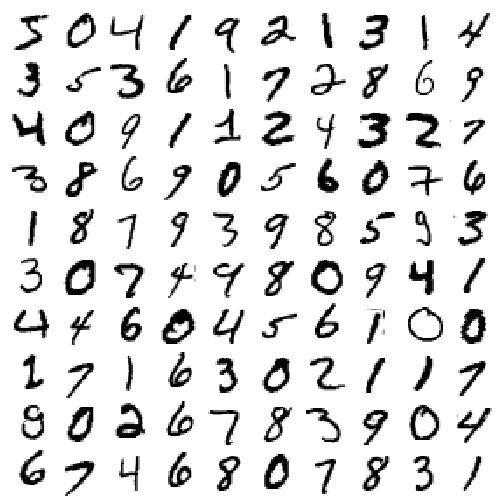

In [23]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)

In [24]:
y = y.astype(np.uint8)

In [25]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Training a Binary Classifier
Let’s create the target vectors for this classification task:

In [26]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

Okay, now let’s pick a classifier and train it. A good place to start is with a Stochastic
Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier
has the advantage of being capable of handling very large datasets efficiently.

In [27]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
sgd_clf.predict([some_digit])

array([ True])

Let’s use the cross_val_score() function to evaluate your SGDClassifier model
using K-fold cross-validation, with three folds. Remember that K-fold crossvalidation
means splitting the training set into K-folds (in this case, three), then making
predictions and evaluating them on each fold using a model trained on the
remaining folds

In [29]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 93% accuracy (ratio of correct predictions) on all cross-validation folds?
This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class:

In [30]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. Beats Nostradamus.

Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confusion
matrix.

In [31]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now you are ready to get the confusion matrix using the confusion_matrix() function.
Just pass it the target classes (y_train_5) and the predicted classes
(y_train_pred):

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. 

The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives).

The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives), while the remaining 3,530 were correctly classified as 5s (true positives).

A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [33]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Precision and Recall
Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [34]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [35]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

Now your 5-detector does not look as shiny as it did when you looked at its accuracy.
When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

The F1 score is the harmonic mean of precision and recall (Equation 3-3). 
Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.
To compute the F1 score, simply call the f1_score() function:

In [36]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

Instead of calling the classifier’s
predict() method, you can call its decision_function() method, which returns a
score for each instance, and then make predictions based on those scores using any
threshold you want:

In [37]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [38]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [39]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents
a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 8,000.

Now how do you decide which threshold to use? For this you will first need to get the
scores of all instances in the training set using the cross_val_predict() function
again, but this time specifying that you want it to return decision scores instead of
predictions:

In [40]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

Now with these scores you can compute precision and recall for all possible thresholds
using the precision_recall_curve() function:

In [41]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, you can plot precision and recall as functions of the threshold value using
Matplotlib

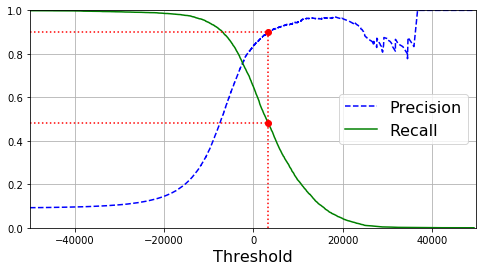

In [42]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro") 

In [43]:
(y_train_pred == (y_scores > 0)).all()

True

Another way to select a good precision/recall tradeoff is to plot precision directly against recall, as shown (the same threshold as earlier is highlighed).

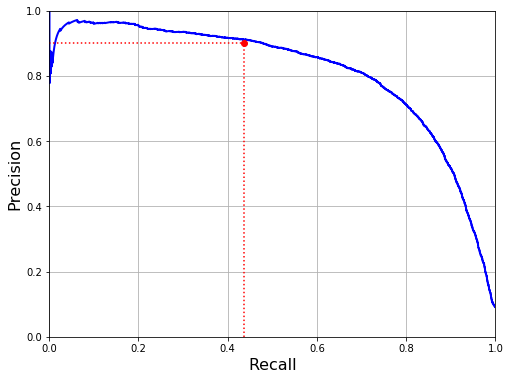

In [44]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")

So let’s suppose you decide to aim for 90% precision. You look up the first plot and
find that you need to use a threshold of about 8,000. To be more precise you can
search for the lowest threshold that gives you at least 90% precision (np.argmax()
will give us the first index of the maximum value, which in this case means the first
True value):

In [47]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816
threshold_90_precision

3370.0194991439557

To make predictions (on the training set for now), instead of calling the classifier’s
predict() method, you can just run this code:

In [48]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [49]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [50]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate. The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
1 – specificity.


In [51]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then you can plot the FPR against the TPR using Matplotlib.

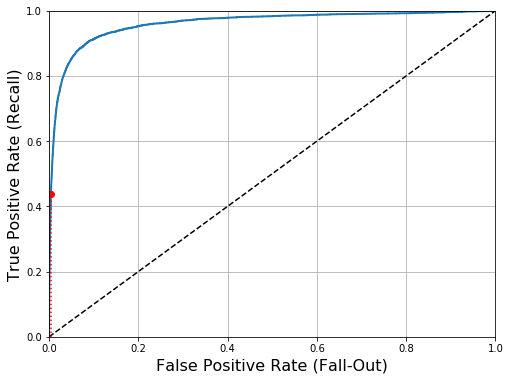

In [52]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown


Once again there is a tradeoff: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).

Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topright
corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:

In [53]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC
score to the SGDClassifier. First, you need to get scores for each instance in the
training set. But due to the way it works, the RandomForestClassi
fier class does not have a decision_function() method. Instead it has a pre
dict_proba() method. Scikit-Learn classifiers generally have one or the other. The
predict_proba() method returns an array containing a row per instance and a column
per class, each containing the probability that the given instance belongs to the
given class (e.g., 70% chance that the image represents a 5):

In [54]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

C:\Users\SZ\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\SZ\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\SZ\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


But to plot a ROC curve, you need scores, not probabilities. A simple solution is to
use the positive class’s probability as the score:

In [55]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as
well to see how they compare

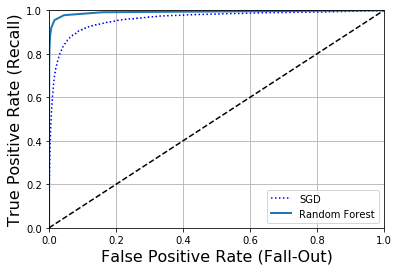

In [56]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

As a
result, its ROC AUC score is also significantly better:

In [57]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

## Multiclass Classification

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are
capable of handling multiple classes directly. Others (such as Support Vector Machine
classifiers or Linear classifiers) are strictly binary classifiers. However, there are various
strategies that you can use to perform multiclass classification using multiple
binary classifiers.

For example, one way to create a system that can classify the digit images into 10
classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a
1-detector, a 2-detector, and so on). This is called the one-versus-all (OvA) strategy
(also called one-versus-the-rest).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish
0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the one-versus-one (OvO) strategy.


In [68]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [69]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [70]:
np.argmax(some_digit_scores)

3

In [71]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [72]:
sgd_clf.classes_[3]

3

Let’s evaluate the SGDClassifier’s accuracy using the cross_val_score()
function:

In [73]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

BUT ITS WRONG PREDICTION :)
It gets over 84% on all test folds. If you used a random classifier, you would get 10%
accuracy, so this is not such a bad score, but you can still do much better. For example,
simply scaling the inputs increases accuracy above 89%:

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\Users\SZ\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

## Error Analysis

Here, we will assume that you have found a promising model and you want
to find ways to improve it. One way to do this is to analyze the types of errors it
makes.

First, you can look at the confusion matrix. You need to make predictions using the
cross_val_predict() function, then call the confusion_matrix() function, just like
you did earlier:

In [77]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\SZ\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]],
      dtype=int64)

That’s a lot of numbers. It’s often more convenient to look at an image representation
of the confusion matrix, using Matplotlib’s matshow() function:

Let’s focus the plot on the errors. First, you need to divide each value in the confusion
matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look
unfairly bad):

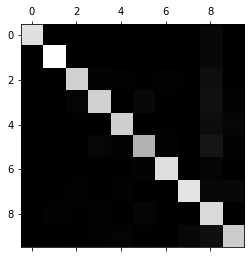

In [78]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Now you can clearly see the kinds of errors the classifier makes. Remember that rows
represent actual classes, while columns represent predicted classes. The column for
class 8 is quite bright, which tells you that many images get misclassified as 8s. However,
the row for class 8 is not that bad, telling you that actual 8s in general get properly
classified as 8s. As you can see, the confusion matrix is not necessarily
symmetrical. You can also see that 3s and 5s often get confused (in both directions).

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

For example, let’s plot examples of 3s and 5s (the plot_digits() function just uses
Matplotlib’s imshow() function; see this chapter’s Jupyter notebook for details):

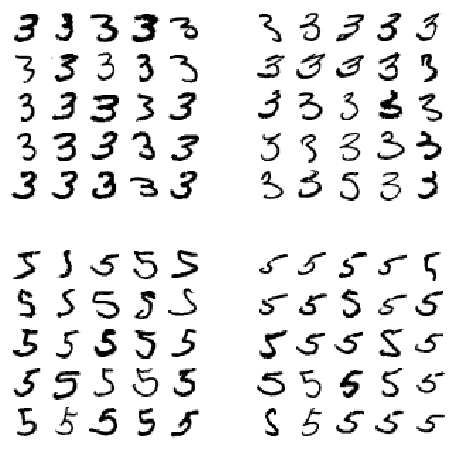

In [79]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5×5 blocks on the left show digits classified as 3s, and the two 5×5 blocks on
the right show images classified as 5s.

Most misclassified images seem like obvious
errors to us, and it’s hard to understand why the classifier made the mistakes it did.3
The reason is that we used a simple SGDClassifier, which is a linear model. All it
does is assign a weight per class to each pixel, and when it sees a new image it just
sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s
differ only by a few pixels, this model will easily confuse them.

So one way to reduce the 3/5 confusion
would be to preprocess the images to ensure that they are well centered and not too
rotated. This will probably help reduce other errors as well.

## Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance.

let’s look at a simpler example, just for
illustration purposes:

In [80]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

This code creates a y_multilabel array containing two target labels for each digit
image: the first indicates whether or not the digit is large (7, 8, or 9) and the second
indicates whether or not it is odd. The next lines create a KNeighborsClassifier
instance (which supports multilabel classification, but not all classifiers do) and we
train it using the multiple targets array. Now you can make a prediction, and notice
that it outputs two labels:

In [81]:
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right! The digit 5 is indeed not large (False) and odd (True).

This code computes the average F1 score across all
labels:

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

f1_score(y_multilabel, y_train_knn_pred, average="macro")

This assumes that all labels are equally important, which may not be the case. In particular,
if you have many more pictures of Alice than of Bob or Charlie, you may want
to give more weight to the classifier’s score on pictures of Alice. One simple option is
to give each label a weight equal to its support (i.e., the number of instances with that
target label). To do this, simply set average="weighted" in the preceding code.

## Multioutput Classification

It is simply a generalization
of multilabel classification where each label can be multiclass (i.e., it can have
more than two possible values).

Notice that the
classifier’s output is multilabel (one label per pixel) and each label can have multiple
values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput
classification system.

Let’s start by creating the training and test sets by taking the MNIST images and
adding noise to their pixel intensities using NumPy’s randint() function. The target
images will be the original images:

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Now
let’s train the classifier and make it clean this image:

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Looks close enough to the target!